## Test Non-circulant

This notebook explicitly tests each step of the non-circulant version of Richardson Lucy to help trouble shoot and debug any issues that may occur with the ```clij2fft.richardson_lucy.richardson_lucy_nc``` implementation. 

In [13]:
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xyz_max
from tnia.io.tifffile_helper import open_ij3D
from clij2fft.pad import pad, get_pad_size, get_next_smooth, unpad
from clij2fft.richardson_lucy import richardson_lucy, richardson_lucy_nc
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
from clij2fft.libs import getlib

In [14]:
input_name="D:\\images\\From Joao Mamede\\F2_laminigfpcarub8am-cropped2.tif" 

im, x_voxel_size, y_voxel_size, z_voxel_size = open_ij3D(input_name)
print(im.shape, x_voxel_size, y_voxel_size, z_voxel_size)

(23, 256, 256) 0.2166666955555594 0.2166666955555594 0.5


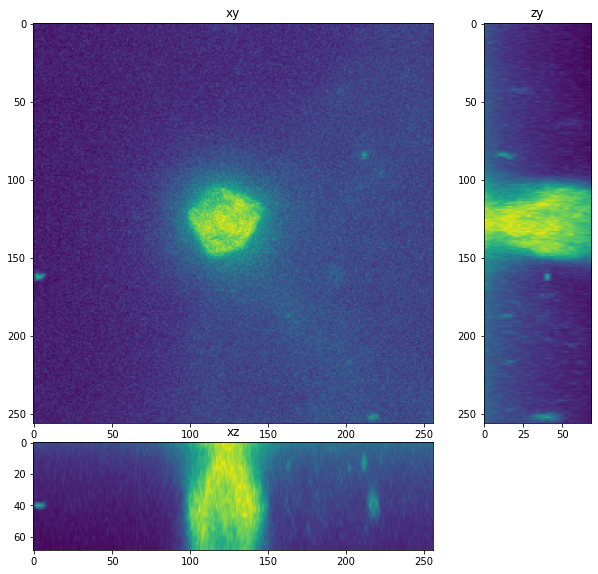

In [15]:
fig=show_xyz_max(im,1,3)

sdeconv 0.x.x detected


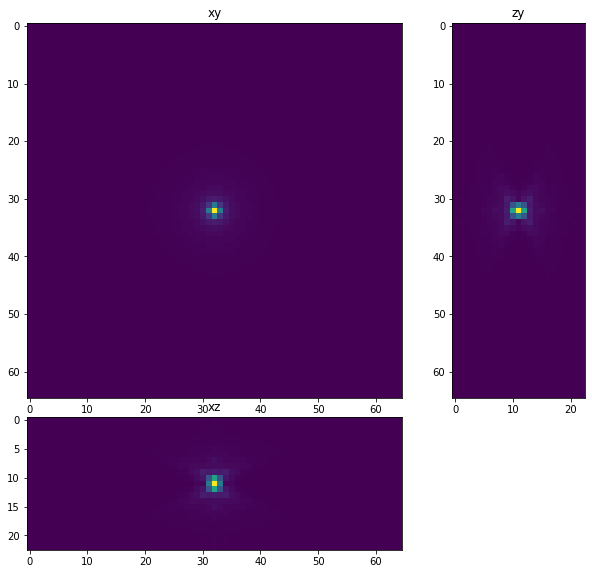

In [16]:
xy_psf_dim=65
z_psf_dim=23

NA=1.4
ni=1.51
ns=1.51

psf = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, 0, 0.5)
psf = psf.astype('float32')
fig=show_xyz_max(psf)

In [17]:
im=im.astype('float32')

In [18]:
original_size = im.shape
print(original_size)

(23, 256, 256)


In [19]:
extended_size = [im.shape[0]+2*int(psf.shape[0]/2), im.shape[1]+2*int(psf.shape[1]/2), im.shape[2]+2*int(psf.shape[2]/2)]
#extended_size = [im.shape[0]+psf.shape[0], im.shape[1]+psf.shape[1], im.shape[2]+psf.shape[2]]
print(im.shape)
print(psf.shape)
print(extended_size)

(23, 256, 256)
(23, 65, 65)
[45, 320, 320]


In [20]:
extended_size = get_next_smooth(extended_size)
print(extended_size)

(45, 320, 320)


In [21]:
# pad image and psf to next smooth size
im, _ = pad(im, extended_size,'constant')
psf, _ = pad(psf, extended_size, 'constant')    

# shift psf so center is at 0,0
shifted_psf = np.fft.ifftshift(psf)


In [22]:
# memory for result
result = np.zeros(im.shape).astype('float32')
result[:,:,:]=im.mean()

In [23]:
start = [0,0,0]
end = [0,0,0]

# calculate the start and end of the original image within the extended image 
for d in range(3):
    start[d] = int((extended_size[d]-original_size[d])/2)
    end[d]=int(start[d]+original_size[d])

valid=np.zeros(extended_size).astype(np.float32)
valid[start[0]:end[0],start[1]:end[1],start[2]:end[2]]=1

In [24]:
normal=np.zeros(extended_size).astype(np.float32)
# if the lib wasn't passed get it
try:
    lib
except:
    print('get lib')
    lib = getlib()

lib.convcorr3d_32f(int(normal.shape[2]   ), int(normal.shape[1]), int(normal.shape[0]), valid, shifted_psf, normal,1)
normal[normal<0.00001]=1

get lib


In [25]:
lib.deconv3d_32f(100, int(im.shape[2]), int(im.shape[1]), int(im.shape[0]), im, shifted_psf, result, normal)

# unpad and return
decon = unpad(result, original_size)

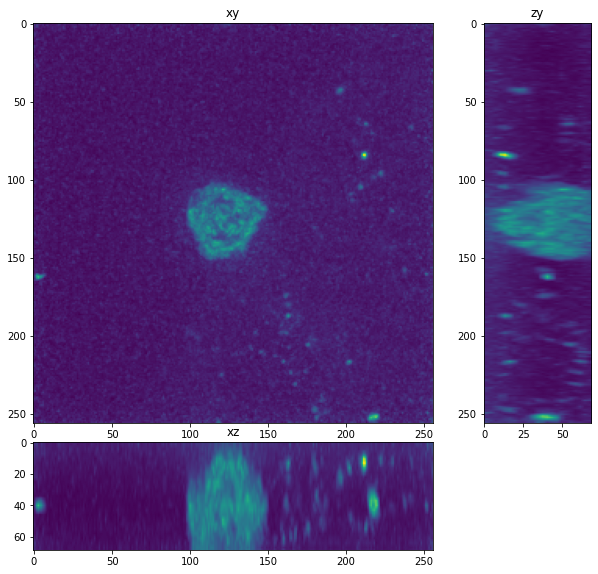

In [27]:
fig=show_xyz_max(decon,1,3)